In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = './results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

### Create dataframe

In [11]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [12]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]

In [13]:
df.head()

,AACS,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AASDH,AASDHPPT,AATF,...,ZNFX1,ZNHIT3,ZNRD2,ZNRF1,ZPR1,ZRANB2,ZSCAN18,ZSCAN21,ZUP1,ZZZ3
human_759_WM,0.041268,0.025707,-0.072019,0.051644,-0.040637,0.007453,-0.047439,0.013681,-0.112373,-0.027305,...,0.002537,-0.145321,-0.012920,-0.019393,0.010821,0.002873,0.018861,0.032487,-0.083505,-0.040384
human_j12_WM,0.025153,-0.044543,0.001885,0.044115,-0.005605,0.064853,-0.020012,0.036537,-0.247531,0.059761,...,0.029141,-0.053724,0.029411,-0.080373,-0.068238,-0.011533,-0.072855,-0.043932,-0.005179,0.055280
human_j3_WM,-0.028083,-0.011412,0.121080,-0.036493,-0.043526,-0.017252,-0.003079,0.047993,-0.150683,0.065300,...,0.026583,-0.017077,0.022215,-0.106516,0.025459,0.008847,-0.013096,-0.029365,0.055279,0.020677
human_j4_WM,-0.020194,-0.054054,0.040012,-0.023853,0.081220,0.055494,-0.012639,-0.001961,-0.177060,0.061381,...,0.055548,-0.082023,0.017378,-0.073447,0.030231,-0.000191,-0.116543,-0.023978,0.012403,0.078987
human_j6_WM,0.004524,0.010688,0.078731,0.049893,-0.014778,-0.074468,-0.035236,-0.024390,0.091938,0.022454,...,-0.049726,-0.146974,0.022209,0.003881,0.070576,0.027428,-0.033470,-0.019749,0.130150,0.027191


### Fit the spline

In [22]:
df_cont = df.copy()
df_cont['condition'] = adata_pb_norm.obs.condition
df_cont['layer'] = adata_pb_norm.obs.layer
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
#df_cont['intercept'] = 1

In [15]:
#df_cont.columns = df_cont.columns.str.replace('-', '')

In [16]:
import numpy as np
np.random.seed(1234)
n = 200
def func(x):
   return x**3 + x**2 * np.sin(4 * x)
x = np.sort(np.random.random_sample(n) * 4 - 2)
y = func(x) + np.random.normal(scale=1.5, size=n)

In [17]:
from scipy.interpolate import make_smoothing_spline, BSpline
spl = make_smoothing_spline(x, y)

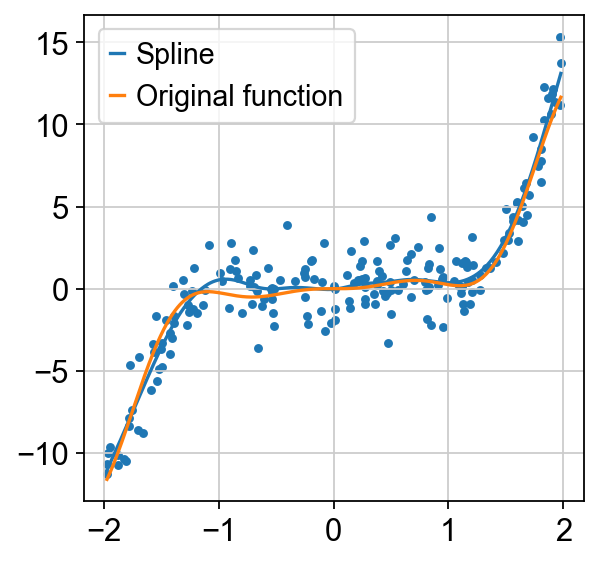

In [18]:
grid = np.linspace(x[0], x[-1], 400)
plt.plot(grid, spl(grid), label='Spline')
plt.plot(grid, func(grid), label='Original function')
plt.scatter(x, y, marker='.')
plt.legend(loc='best')
plt.show()

In [95]:
from scipy.interpolate import UnivariateSpline
gene = 'AAR2'
subs_index = df_cont[df_cont.condition == 'human'].index
targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
x = targ_dataset['layer'].values
y = targ_dataset[gene].values
spl = UnivariateSpline(x, y, k=3)

#model = ols(formula, data=df_cont, subset=subs_index).fit()
#model_list.append([formula_index, model.f_pvalue])

In [92]:
layer_mean = (
    targ_dataset
    .drop('condition', axis=1)
    .groupby('layer')
    .mean()[gene]
)

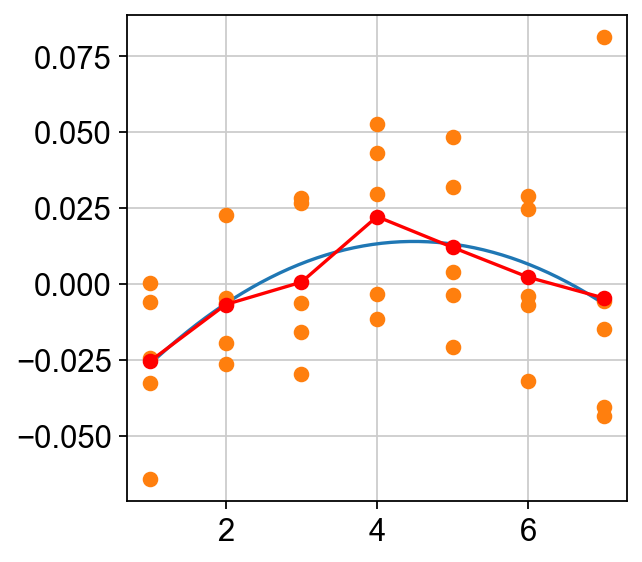

In [93]:
grid = np.linspace(1, 7)
plt.plot(grid, spl(grid), label='Spline')
plt.plot(x, y, 'o')
plt.plot(np.arange(1, 8), layer_mean, 'r-o')
#plt.scatter(x, y, marker='.')
#plt.legend(loc='best')
plt.show()

In [98]:
gene = 'AAR2'
ref_specie, sec_specie = 'human', 'chimp'

subs_index = df_cont[df_cont.condition == ref_specie].index
targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
x = targ_dataset['layer'].values
y = targ_dataset[gene].values
spl_ref = UnivariateSpline(x, y, k=3)
res_ref = spl_ref.get_residual()

# fit spline for second specie
subs_index = df_cont[df_cont.condition == sec_specie].index
targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
x = targ_dataset['layer'].values
y = targ_dataset[gene].values
spl_sec = UnivariateSpline(x, y, k=3)
res_sec = spl_sec.get_residual()

# fit spline for both species
subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
x = targ_dataset['layer'].values
y = targ_dataset[gene].values
spl_both = UnivariateSpline(x, y, k=3)
res_both = spl_both.get_residual()

# calculate f_stat
f_stat = (res_both - res_ref - res_sec) / (res_ref + res_sec)

0.1032158198635791

In [151]:
from itertools import permutations, combinations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
#permut = list(combinations(conditions, 2))
permut = list(combinations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    #not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(df.columns):
        # fit spline for ref specie
        subs_index = df_cont[df_cont.condition == ref_specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl_ref = UnivariateSpline(x, y, k=3)
        res_ref = spl_ref.get_residual()

        # fit spline for second specie
        subs_index = df_cont[df_cont.condition == sec_specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl_sec = UnivariateSpline(x, y, k=3)
        res_sec = spl_sec.get_residual()

        # fit spline for both species
        subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl_both = UnivariateSpline(x, y, k=3)
        res_both = spl_both.get_residual()

        # calculate f_stat
        f_stat = (res_both - res_ref - res_sec) / (res_ref + res_sec)
        

        

        res_list.append(model2.compare_f_test(model1))
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value', 'df'], index=df.columns)

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [153]:
res_dict.keys()

dict_keys(['human-chimp', 'human-macaque', 'chimp-human', 'chimp-macaque', 'macaque-human', 'macaque-chimp'])

In [154]:
res_df = res_dict['human-chimp']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AAK1,3.170040,0.049499,2.0
ABCC10,4.628219,0.013722,2.0
ABCC5,3.378435,0.041060,2.0
ABLIM3,3.149486,0.032116,3.0
ACHE,4.038932,0.022887,2.0
...,...,...,...
ZMAT2,3.554717,0.020034,3.0
ZMYM2,3.911086,0.025604,2.0
ZMYND8,10.124459,0.000173,2.0
ZNF608,4.444364,0.016081,2.0


In [155]:
res_df = res_dict['human-macaque']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AAK1,8.817821,4.460933e-04,2.0
AATK,15.667631,1.291293e-08,4.0
ABTB1,10.818979,9.936157e-05,2.0
ACSBG1,11.825792,5.311734e-07,4.0
ACSL1,11.082060,8.201511e-05,2.0
...,...,...,...
ZMYND11,4.175666,2.013361e-02,2.0
ZMYND8,6.450877,2.926306e-03,2.0
ZNF330,3.919225,2.522646e-02,2.0
ZNF33A,3.477649,2.165949e-02,3.0


<Axes: >

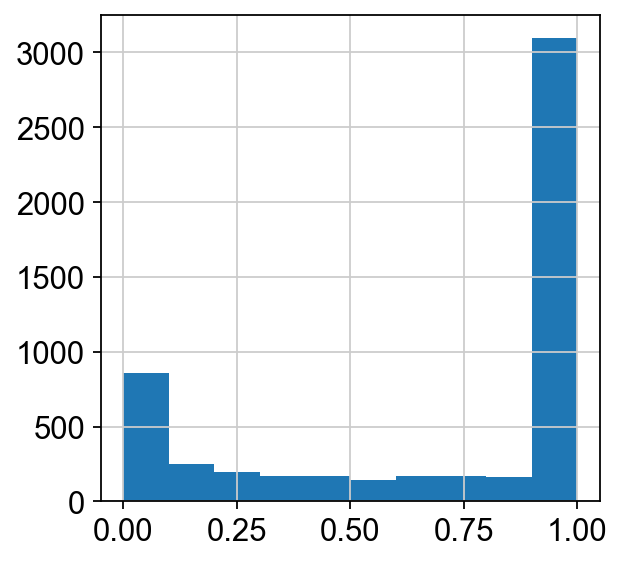

In [156]:
res_df['p-value'].hist()

In [157]:
import pickle

with open('results/ancova_res.pkl', 'wb') as f:
    pickle.dump(res_dict, f)

# Visualise

In [158]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in res_dict.items()}
sign_genes

{'human-chimp': Index(['AAK1', 'ABCC10', 'ABCC5', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTN2', 'ADORA1',
        'AGFG1', 'AHI1',
        ...
        'ZBTB14', 'ZBTB17', 'ZBTB46', 'ZFP37', 'ZFPL1', 'ZMAT2', 'ZMYM2',
        'ZMYND8', 'ZNF608', 'ZNF692'],
       dtype='object', length=385),
 'human-macaque': Index(['AAK1', 'AATK', 'ABTB1', 'ACSBG1', 'ACSL1', 'ACVR1B', 'ADAM11',
        'ADGRB2', 'ADPRS', 'AFDN',
        ...
        'YARS1', 'YWHAE', 'ZBTB18', 'ZBTB46', 'ZFP90', 'ZMYND11', 'ZMYND8',
        'ZNF330', 'ZNF33A', 'ZNF827'],
       dtype='object', length=660),
 'chimp-human': Index(['ABCG4', 'ACSL1', 'ACSS2', 'ACTN2', 'ADORA1', 'AHNAK2', 'AK1', 'AK2',
        'AKAP7', 'AKT3',
        ...
        'WDR37', 'WDR45', 'WDR83', 'ZBTB17', 'ZBTB46', 'ZFAND2B', 'ZFP37',
        'ZMYND8', 'ZNF689', 'ZNF692'],
       dtype='object', length=325),
 'chimp-macaque': Index(['ABCD3', 'ACAD9', 'ACOT13', 'ACTG1', 'ACTN2', 'ADAM19', 'ADGRB1',
        'ADPGK', 'AK5', 'AKAP7',
        ...
        'WIF1',

In [164]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque']).difference(sign_genes['macaque-chimp'])
hs_genes, hs_genes.size

(Index(['AAK1', 'AHI1', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2', 'ARHGEF1', 'ASPHD2',
        'ATAD1', 'ATP1A3',
        ...
        'TMEM108', 'TMEM54', 'TMEM59L', 'USP9X', 'VAT1L', 'VGLL4', 'VPS51',
        'XPNPEP1', 'YWHAE', 'ZBTB46'],
       dtype='object', length=108),
 108)

In [165]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['chimp-human']).difference(sign_genes['macaque-human']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACTN2', 'AKAP7', 'ALKBH5', 'ANKRD29', 'AQP11', 'BMT2', 'BOLA3',
        'CDIPT', 'CEP85L', 'COG7', 'COX15', 'CPSF4', 'DNAJC4', 'ECSIT', 'FLII',
        'GIPC1', 'GNG7', 'GTPBP1', 'HCCS', 'HSPB11', 'IDH3G', 'KLF3', 'KLHL32',
        'LCMT1', 'LDHB', 'LMO3', 'LONP2', 'LYPD6', 'MAFG', 'MAP3K7', 'MCUB',
        'MRPL23', 'NR2F6', 'NUP93', 'PIK3R4', 'PIP4K2C', 'PML', 'POP5',
        'PPP4R3B', 'PTOV1', 'PTP4A2', 'RARS1', 'RCAN2', 'RCHY1', 'RING1',
        'RNF2', 'SAP30BP', 'SDCBP2', 'SEMA3A', 'SETD1B', 'SETDB2', 'SLC4A1AP',
        'SMARCA1', 'STARD4', 'SULF1', 'TALDO1', 'TBPL1', 'TM2D1', 'TMCC2',
        'TMEM126B', 'TRMT61B', 'TUSC2', 'WDR37', 'WDR83', 'ZBTB17', 'ZFAND2B'],
       dtype='object'),
 66)

In [166]:
ms_genes = sign_genes['macaque-chimp'].intersection(sign_genes['macaque-human']).difference(sign_genes['human-chimp']).difference(sign_genes['chimp-human'])
ms_genes, ms_genes.size

(Index(['AATK', 'ABAT', 'ABCD4', 'ABTB1', 'ACAD9', 'ACSBG1', 'ADAM19', 'ADGRB1',
        'AIDA', 'AKR1A1',
        ...
        'ZDHHC24', 'ZDHHC8', 'ZDHHC9', 'ZNF140', 'ZNF184', 'ZNF304', 'ZNF408',
        'ZNF48', 'ZNF576', 'ZNF606'],
       dtype='object', length=468),
 468)